In [1]:
import pandas as pd
import numpy as np
import gc

import os
import sys
sys.path.append("../")

from Feature.feature import Feature
import Tool.config as config

from sklearn.metrics import log_loss
from sklearn import preprocessing
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

In [2]:
data = pd.read_pickle(config.data_prefix_path + 'data.pkl')

In [3]:
# 还有一种方法，将config.CATEGORICAL_COLS都作为类别特征
object_features = ["predict_category_1","predict_category_2","predict_category_0",
                    "predict_property_0","predict_property_1","predict_property_2",
                    "property_1","property_0","property_2",
                    "category_0",
                    'hour_and_category_1',
                    'category_cross_0', 'category_cross_1', 'category_cross_2',
                    ]

In [4]:
cat_features = ['user_gender_id','user_occupation_id',"category_1","category_2",'hour']

In [5]:
features = [c for c in data.columns if c not in ['is_trade', 'instance_id','index',
                                            'context_id', 'time', 'day','context_timestamp',
                                            'property_list','category_list','property_predict_list','category_predict_list',
                                            'item_category_list', 'item_property_list', 'predict_category_property',
                                            'user_id','item_id','item_brand_id','item_city_id','user_id','shop_id',
                                            ]
            and c not in object_features]
target = ['is_trade']

In [6]:

labelEncoding = preprocessing.LabelEncoder()
data['predict_category_0'] = data['predict_category_0'].apply(lambda x:np.nan if x == '-1' else x)
for col in cat_features:
    data[col] = labelEncoding.fit_transform(data[col].astype(str))


In [7]:
train = data[data.is_trade.notnull()]
test = data[data.is_trade.isnull()]
del data
gc.collect()

182

In [8]:
print(train.shape)
print(test.shape)

(478032, 361)
(42888, 361)


In [9]:
# specify your configurations as a dict
params = {
    
# 核心参数
'task': 'train',# 设置是否是训练任务
'objective': 'binary',# 设置目标  =='application': 'binary',
'boosting_type': 'gbdt',# 设置模型
'num_iterations': 2000,# 最大循环次数
'learning_rate': 0.03,# 学习率
'num_leaves': 35,# 设置一棵树最多有几个叶子，越大越容易过拟合
#'tree_learner':'tree_learner' # 设置并行学习
'num_threads':7,# 指定多少个线程
#'device':'cpu',# 指定设备GPU／cpu

# 学习控制参数
'max_depth':8,# 限制树模型的最大深度，用于减少过拟合，<0表示没有限制
#'min_data_in_leaf':20,# 一个叶子中最少数据个数，用于制止过拟合
#'min_sum_hessian_in_leaf':0.00001,# minimal sum hessian in one leaf,制止过拟合
#'feature_fraction':1.0,# 随机抽取的特征列的占比，用于加快训练和防止过拟合
#'feature_fraction_seed':2,# 随机抽取的特征列的随机产生种子
#'bagging_fraction':1.0,# 随机选择部分数据的占比，用于加快训练和防止过拟合
#'bagging_freq':1,# 每隔k次就进行随机bagging，k=0表示不bagging
#'bagging_seed':3,# bagging的随机产生种子
#'lambda_l1':0,# L1 regularization
#'lambda_l2':10,# L2 regularization
#'min_split_gain':0,# 分裂一次最少要获取多少收益
#'max_cat_threshold':32,# limit the max threshold points in categorical features
#'cat_smooth':10,# 减少类别变量的噪声污染，对于少数据的类别
'cat_l2':4,# 类别分类的L2正则
#'max_cat_to_onehot':4,# 当一个类别总数少于等于4，使用one-vs-other分裂算法
'colsample_bytree':0.8,#在建立树时对特征采样的比例。缺省值为1
'subsample':0.9,#用于训练模型的子样本占整个样本集合的比例。   
# IO参数
#'max_bin':255, #max number of bins that feature values will be bucketed in,小的值可能减少精度，但增加泛化能力
#'min_data_in_bin':3, # min number of data inside one bin, use this to avoid one-data-one-bin (may over-fitting)
#'data_random_seed':1, # random seed for data partition in parallel learning (not include feature parallel)
#'input_model':"" # 训练任务将会继续训练，预测任务直接预测结果
#'is_sparse':True # 离散优化
'verbose': 0,# 是否报出信息，<0 = Fatal, =0 = Error (Warn), >0 = Info

#'bin_construct_sample_cnt':200000 # will give better training result when set this larger, but will increase data loading time
#'num_iteration_predict':-1, # 只用于预测任务，指定用多少训练迭代次数来进行预测，-1表示无限制
#'pred_early_stop':false,# if true will use early-stopping to speed up the prediction. May affect the accuracy
#'use_missing':true,# set to false to disable the special handle of missing value

#目标参数
#'is_unbalance':True,# set this to true if training data are unbalance
    
#指标参数
'eval_metric': 'logloss',#logloss
}

## 线下验证

In [10]:
X_train = train[train.day < 24]
X_val = train[train.day == 24]

In [11]:
print(X_train.shape)
print(X_val.shape)

(420627, 361)
(57405, 361)


In [10]:
train_X = X_train[features].values
train_Y = X_train[target].values.ravel()
val_X = X_val[features].values
val_Y = X_val[target].values.ravel()

In [11]:
del X_train,X_val
gc.collect()

26

In [13]:
# create dataset for lightgbm
lgb_train = lgb.Dataset\
        (data=train_X, label=train_Y,feature_name=features,categorical_feature=cat_features)
lgb_eval = lgb.Dataset\
        (data=val_X, label=val_Y,feature_name=features,categorical_feature=cat_features, reference=lgb_train)


In [14]:
gbm = lgb.train(params,lgb_train,\
                valid_sets=[lgb_train,lgb_eval],early_stopping_rounds=80,
                categorical_feature=cat_features,verbose_eval=1)#


c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	training's binary_logloss: 0.665774	valid_1's binary_logloss: 0.665625
Training until validation scores don't improve for 80 rounds.
[2]	training's binary_logloss: 0.639996	valid_1's binary_logloss: 0.639704
[3]	training's binary_logloss: 0.615679	valid_1's binary_logloss: 0.615254
[4]	training's binary_logloss: 0.59271	valid_1's binary_logloss: 0.59214
[5]	training's binary_logloss: 0.570982	valid_1's binary_logloss: 0.570274
[6]	training's binary_logloss: 0.550403	valid_1's binary_logloss: 0.549561
[7]	training's binary_logloss: 0.530888	valid_1's binary_logloss: 0.529921
[8]	training's binary_logloss: 0.512365	valid_1's binary_logloss: 0.511283
[9]	training's binary_logloss: 0.494763	valid_1's binary_logloss: 0.493584
[10]	training's binary_logloss: 0.478023	valid_1's binary_logloss: 0.476754
[11]	training's binary_logloss: 0.462089	valid_1's binary_logloss: 0.4607
[12]	training's binary_logloss: 0.44691	valid_1's binary_logloss: 0.445417
[13]	training's binary_logloss: 0.432437

[210]	training's binary_logloss: 0.0828833	valid_1's binary_logloss: 0.0801264
[211]	training's binary_logloss: 0.0828346	valid_1's binary_logloss: 0.080116
[212]	training's binary_logloss: 0.082787	valid_1's binary_logloss: 0.0801121
[213]	training's binary_logloss: 0.0827341	valid_1's binary_logloss: 0.080106
[214]	training's binary_logloss: 0.0826842	valid_1's binary_logloss: 0.0800879
[215]	training's binary_logloss: 0.0826396	valid_1's binary_logloss: 0.0800798
[216]	training's binary_logloss: 0.0825901	valid_1's binary_logloss: 0.0800744
[217]	training's binary_logloss: 0.0825427	valid_1's binary_logloss: 0.080063
[218]	training's binary_logloss: 0.0824928	valid_1's binary_logloss: 0.0800465
[219]	training's binary_logloss: 0.0824493	valid_1's binary_logloss: 0.0800348
[220]	training's binary_logloss: 0.0824002	valid_1's binary_logloss: 0.0800215
[221]	training's binary_logloss: 0.0823542	valid_1's binary_logloss: 0.080021
[222]	training's binary_logloss: 0.0823132	valid_1's bina

[418]	training's binary_logloss: 0.0755274	valid_1's binary_logloss: 0.0796701
[419]	training's binary_logloss: 0.0755058	valid_1's binary_logloss: 0.0796692
[420]	training's binary_logloss: 0.0754762	valid_1's binary_logloss: 0.0796672
[421]	training's binary_logloss: 0.0754507	valid_1's binary_logloss: 0.0796636
[422]	training's binary_logloss: 0.0754195	valid_1's binary_logloss: 0.0796613
[423]	training's binary_logloss: 0.0753964	valid_1's binary_logloss: 0.079665
[424]	training's binary_logloss: 0.0753793	valid_1's binary_logloss: 0.0796659
[425]	training's binary_logloss: 0.0753535	valid_1's binary_logloss: 0.0796646
[426]	training's binary_logloss: 0.0753181	valid_1's binary_logloss: 0.0796699
[427]	training's binary_logloss: 0.0752881	valid_1's binary_logloss: 0.0796705
[428]	training's binary_logloss: 0.0752557	valid_1's binary_logloss: 0.0796732
[429]	training's binary_logloss: 0.0752257	valid_1's binary_logloss: 0.0796751
[430]	training's binary_logloss: 0.075204	valid_1's b

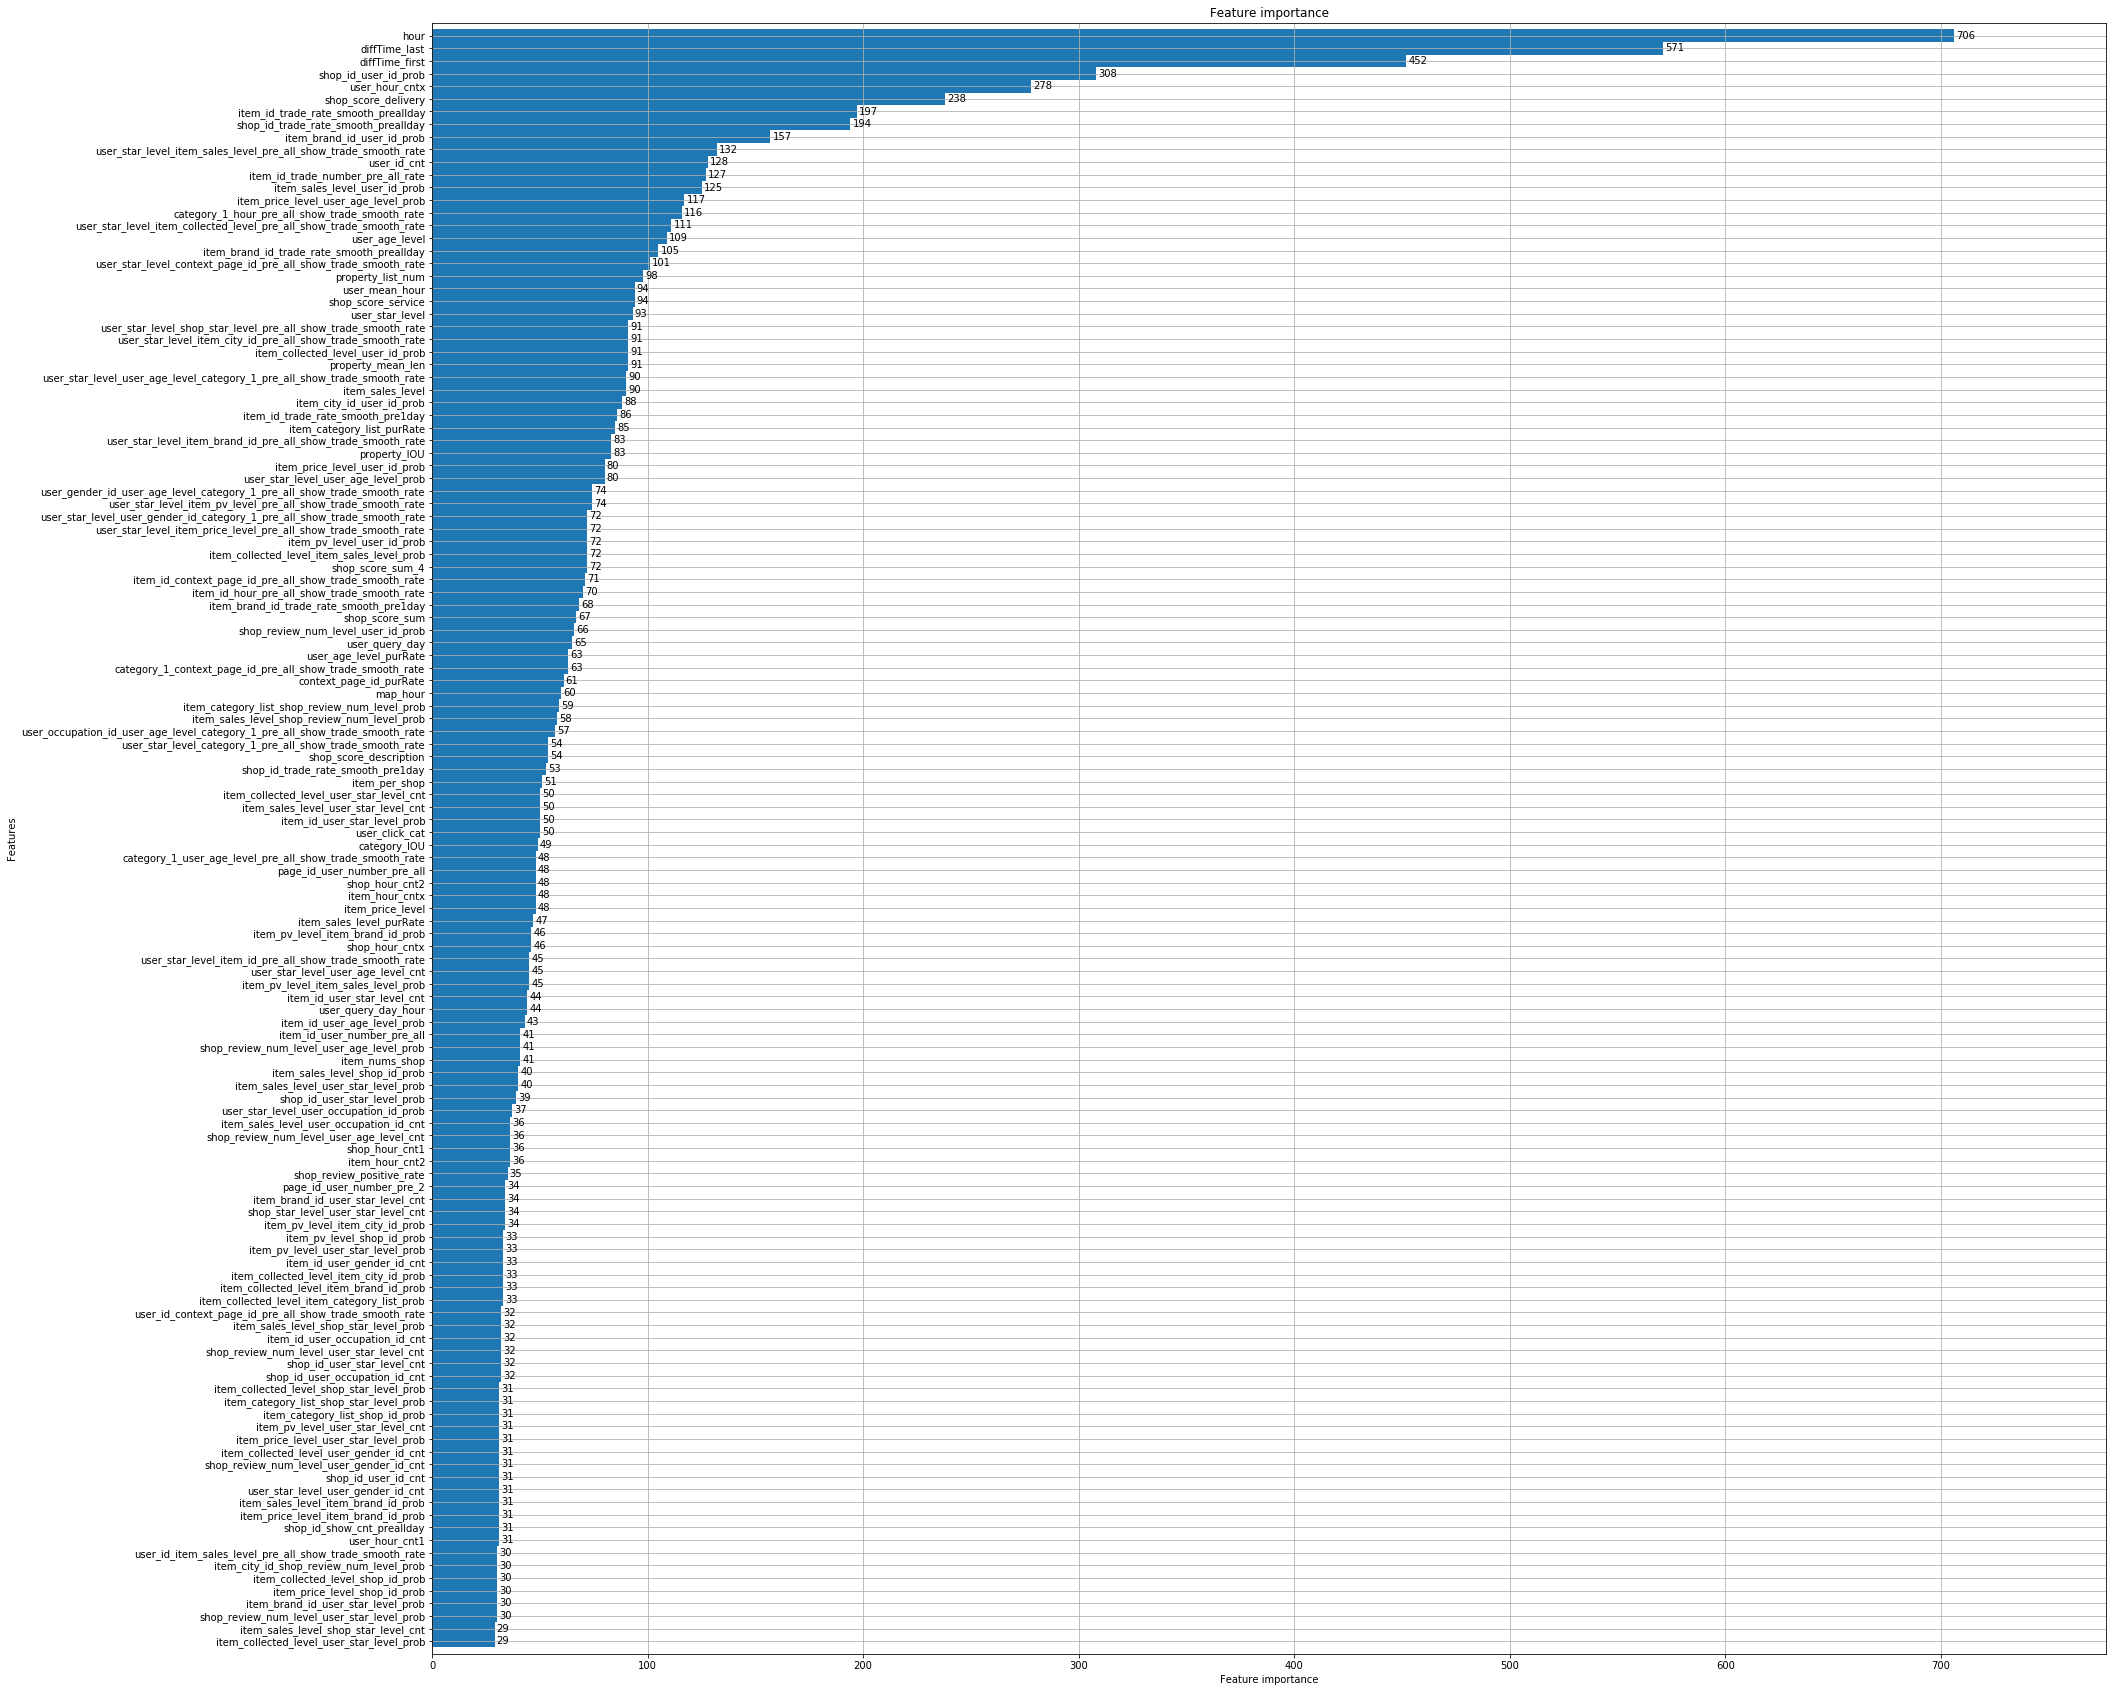

In [15]:
fig,ax = plt.subplots(figsize=(30,30))
lgb.plot_importance(gbm,
                  height=1,
                  ax=ax,
                  max_num_features=128)
plt.show()

In [16]:
del gbm
del lgb_train,lgb_eval
del train_X,train_Y,val_X,val_Y

## 线上提交

In [9]:
train_X = train[features].values
train_Y = train[target].values.ravel()
test_X = test[features].values

In [10]:
del train
gc.collect()

39

In [11]:
lgb_train = lgb.Dataset\
        (data=train_X, label=train_Y,feature_name=features,categorical_feature = cat_features)

In [12]:
del train_X,train_Y
gc.collect()

0

In [14]:
gbm = lgb.train(params,lgb_train,\
                valid_sets=[lgb_train],num_boost_round=400,
                categorical_feature=cat_features,verbose_eval=5)

[5]	training's binary_logloss: 0.570854
[10]	training's binary_logloss: 0.477793
[15]	training's binary_logloss: 0.40514
[20]	training's binary_logloss: 0.3474
[25]	training's binary_logloss: 0.300922
[30]	training's binary_logloss: 0.263158
[35]	training's binary_logloss: 0.232262
[40]	training's binary_logloss: 0.206857
[45]	training's binary_logloss: 0.18589
[50]	training's binary_logloss: 0.168543
[55]	training's binary_logloss: 0.154173
[60]	training's binary_logloss: 0.142256
[65]	training's binary_logloss: 0.132374
[70]	training's binary_logloss: 0.124179
[75]	training's binary_logloss: 0.11739
[80]	training's binary_logloss: 0.111768
[85]	training's binary_logloss: 0.107116
[90]	training's binary_logloss: 0.103273
[95]	training's binary_logloss: 0.100091
[100]	training's binary_logloss: 0.0974588
[105]	training's binary_logloss: 0.0952834
[110]	training's binary_logloss: 0.0934857
[115]	training's binary_logloss: 0.0919881
[120]	training's binary_logloss: 0.0907411
[125]	traini

In [20]:
test['predicted_score'] = gbm.predict(test_X)

In [21]:
test[['instance_id', 'predicted_score']].to_csv(config.data_prefix_path + 'sub0419_lightgbm.txt',sep=" ",index=False)

## oof

In [10]:
from sklearn.model_selection import KFold
folds=KFold(n_splits=4,random_state=2018,shuffle=True)

In [11]:
del test
gc.collect()

0

In [12]:
pred = np.zeros(len(train))
iters = 0

X_train = train[features].values
y_train = train['is_trade'].values

In [15]:
for n_fold,(trn_idx,val_idx) in enumerate(folds.split(X_train,y_train)):
    
    lgb_train = lgb.Dataset\
        (data=X_train[trn_idx], label=y_train[trn_idx],
         feature_name=features,categorical_feature=cat_features)
    
    lgb_eval = lgb.Dataset\
        (data=X_train[val_idx], label=y_train[val_idx],
         feature_name=features,categorical_feature=cat_features, reference=lgb_train)
    
    model = lgb.train(
        params = params,
        train_set = lgb_train,
        num_boost_round = 1000,
        valid_sets = [lgb_train,lgb_eval],
        early_stopping_rounds = 80,
        categorical_feature = cat_features,
        verbose_eval = 0)
    
    pred[val_idx] = model.predict(X_train[val_idx],num_iteration=model.best_iteration)
    loss = log_loss(y_train[val_idx],pred[val_idx])
    iters += model.best_iteration
    print("\t Fold %d : %.6f in %3d rounds" % (n_fold + 1, loss, model.best_iteration))

iters /= 4
print("平均迭代次数： "+str(iters))
train['is_trade'+'_oof'] = pred

c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


	 Fold 1 : 0.086073 in 459 rounds
	 Fold 2 : 0.087169 in 352 rounds
	 Fold 3 : 0.086706 in 398 rounds
	 Fold 4 : 0.086612 in 357 rounds
平均迭代次数： 416.5


In [16]:
# 保存结果,用作stacking
train[['instance_id', 'is_trade', 'is_trade'+'_oof']].to_csv(
    config.data_prefix_path + 'lightgbm_oof.txt',sep=" ",index=False
    )